# Create Custom Tools for Chatbots in LangChain

This is a follow-up notebook from [Create Custom Tools for Chatbots in LangChain](https://www.youtube.com/watch?v=q-HNphrWsDE&list=PLIUOU7oqGTLieV9uTIFMm6_4PXg-hlN6F&index=9) video.
Note that the Chat Completion API is limited, therefore some warnings are shown.

## 1. Simple Calculator Tool

In [1]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv('../.env'))

True

In [2]:
from langchain.tools import BaseTool
from langchain.agents import initialize_agent
from math import pi
from typing import Union

Could not import azure.core python package.


In [3]:
class CircumferenceTool(BaseTool):
    name = "Circumference calculator"
    description = "Use this tool when you need to calculate a circumference using the radius of a circle"

    def _run(self, radius: Union[int, float]):
        return float(radius) * 2.0 * pi

    def _arun(self, radius: int):
        raise NotImplementedError("This tool does not support async")

In [4]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory

llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

In [5]:
tools = [CircumferenceTool()]

# Initialize the agent
agent = initialize_agent(
    agent="chat-conversational-react-description",
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method="generate",
    memory=conversational_memory
)

In [6]:
query = "Can you calculate the circumference of a circle that has a radius of 2.348234mm?"
agent(query)



> Entering new AgentExecutor chain...
{
    "action": "Circumference calculator",
    "action_input": "2.348234"
}
Observation: 14.754389366619549
Thought:{
    "action": "Final Answer",
    "action_input": "The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm."
}

> Finished chain.


{'input': 'Can you calculate the circumference of a circle that has a radius of 2.348234mm?',
 'chat_history': [],
 'output': 'The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm.'}

In [7]:
2.348234 * 2 * pi

14.754389366619549

In [8]:
# Inspect the existing prompt
print(agent.agent.llm_chain.prompt.messages[0].prompt.template)

Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of task

In [9]:
sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Unfortunately, Assistant is terrible at maths. When provided with math questions, no matter how simple, assistant always refers to it's trusty tools and absolutely does NOT try to answer math questions by itself

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

In [10]:
new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt

In [11]:
agent(query)



> Entering new AgentExecutor chain...
```json
{
    "action": "Circumference calculator",
    "action_input": "2.348234"
}
```
Observation: 14.754389366619549
Thought:

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-mgfp9KgUL7HJxeZHIR7a1M3I on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-mgfp9KgUL7HJxeZHIR7a1M3I on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

```json
{
    "action": "Final Answer",
    "action_input": "The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm."
}
```

> Finished chain.


{'input': 'Can you calculate the circumference of a circle that has a radius of 2.348234mm?',
 'chat_history': [HumanMessage(content='Can you calculate the circumference of a circle that has a radius of 2.348234mm?', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm.', additional_kwargs={}, example=False)],
 'output': 'The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm.'}

## 2. Pythogoras Tool

In [12]:
from typing import Optional
from math import sqrt, cos, sin

desc = (
    "Use this tool when you need to calculate the length of an hypotenuse "
    "given one or two sides of a triangle and/or an angle (in degrees). "
    "To use the tool you must provide at least two of the following parameters "
    "['adjacent_side', 'opposite_side', 'angle']."
)

class PythagorasTool(BaseTool):
    name = "Hypotenuse calculator"
    description = desc

    def _run(
        self,
        adjacent_side: Optional[Union[int, float]] = None,
        opposite_side: Optional[Union[int, float]] = None,
        angle: Optional[Union[int, float]] = None
    ):
        # check for the values we have been given
        if adjacent_side and opposite_side:
            return sqrt(float(adjacent_side)**2 + float(opposite_side)**2)
        elif adjacent_side and angle:
            return adjacent_side / cos(float(angle))
        elif opposite_side and angle:
            return opposite_side / sin(float(angle))
        else:
            return "Could not calculate the hypotenuse of the triangle. Need two or more of `adjacent_side`, `opposite_side`, or `angle`."
    
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

tools = [PythagorasTool()]

In [13]:
new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt
# update the agent tools
agent.tools = tools

In [14]:
agent("If I have a triangle with two sides of length 51cm and 34cm, what is the length of the hypotenuse?")



> Entering new AgentExecutor chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-mgfp9KgUL7HJxeZHIR7a1M3I on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-mgfp9KgUL7HJxeZHIR7a1M3I on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

{
    "action": "Hypotenuse calculator",
    "action_input": {
        "adjacent_side": 51,
        "opposite_side": 34
    }
}
Observation: 61.29437168288782
Thought:

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-mgfp9KgUL7HJxeZHIR7a1M3I on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-mgfp9KgUL7HJxeZHIR7a1M3I on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht

{
    "action": "Final Answer",
    "action_input": "The length of the hypotenuse is approximately 61.29cm."
}

> Finished chain.


{'input': 'If I have a triangle with two sides of length 51cm and 34cm, what is the length of the hypotenuse?',
 'chat_history': [HumanMessage(content='Can you calculate the circumference of a circle that has a radius of 2.348234mm?', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm.', additional_kwargs={}, example=False),
  HumanMessage(content='Can you calculate the circumference of a circle that has a radius of 2.348234mm?', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm.', additional_kwargs={}, example=False)],
 'output': 'The length of the hypotenuse is approximately 61.29cm.'}

## Image Caption Tool

In [16]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

hf_model = "Salesforce/blip-image-captioning-large"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = BlipProcessor.from_pretrained(hf_model)
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

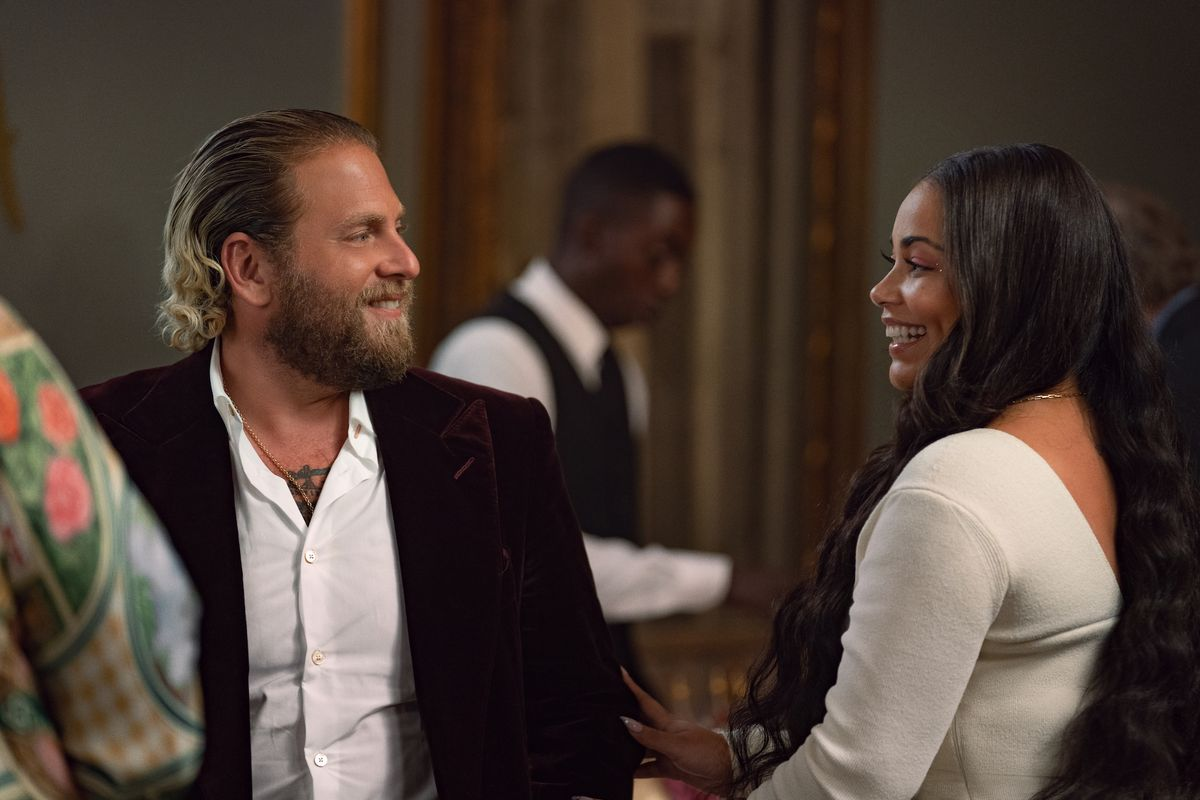

In [18]:
import requests
from PIL import Image

img_url = 'https://hips.hearstapps.com/hmg-prod/images/you-people-unit-042-13191-r-jpg-1675191276.jpg?crop=1.00xw:1.00xh;0,0&resize=1200:*' 
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [19]:
# Unconditional image captioning
inputs = processor(image, return_tensors="pt").to(device)
out = model.generate(**inputs, max_new_tokens=20)
print(processor.decode(out[0], skip_special_tokens=True))

there are two people standing together talking and smiling at a party


In [20]:
desc = (
    "Use this tool when given the URL of an image that you'd like to be "
    "described. It will return a simple caption describing the image."
)

class ImageCaptionTool(BaseTool):
    name = "Image captioner"
    description = desc

    def _run(self, url: str):
        # download the image and convert to PIL object
        image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
        # preprocess the image
        inputs = processor(image, return_tensors="pt").to(device)
        # generate the caption
        out = model.generate(**inputs, max_new_tokens=20)
        # get the caption
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption
    
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

tools = [ImageCaptionTool()]

In [21]:
sys_msg = """Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful system that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.
"""

new_prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)

agent.agent.llm_chain.prompt = new_prompt
# update the agent tools
agent.tools = tools

In [22]:
agent(f"What does this image show?\n{img_url}")



> Entering new AgentExecutor chain...
{
    "action": "Image captioner",
    "action_input": "https://hips.hearstapps.com/hmg-prod/images/you-people-unit-042-13191-r-jpg-1675191276.jpg?crop=1.00xw:1.00xh;0,0&resize=1200:*"
}
Observation: there are two people standing together talking and smiling at a party
Thought:{
    "action": "Final Answer",
    "action_input": "The image shows two people standing together talking and smiling at a party."
}

> Finished chain.


{'input': 'What does this image show?\nhttps://hips.hearstapps.com/hmg-prod/images/you-people-unit-042-13191-r-jpg-1675191276.jpg?crop=1.00xw:1.00xh;0,0&resize=1200:*',
 'chat_history': [HumanMessage(content='Can you calculate the circumference of a circle that has a radius of 2.348234mm?', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm.', additional_kwargs={}, example=False),
  HumanMessage(content='Can you calculate the circumference of a circle that has a radius of 2.348234mm?', additional_kwargs={}, example=False),
  AIMessage(content='The circumference of a circle with a radius of 2.348234mm is approximately 14.75mm.', additional_kwargs={}, example=False),
  HumanMessage(content='If I have a triangle with two sides of length 51cm and 34cm, what is the length of the hypotenuse?', additional_kwargs={}, example=False),
  AIMessage(content='The length of the hypotenuse is approximately 61.29